<a href="https://colab.research.google.com/github/Dheerajjoe/Cats_vs_dogs/blob/master/Cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Welcome!**

*Cats and dogs with Transfer Learning.*

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Mounting the Google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading the data with Tensorflow and Hub**

Spliting a data in suitable percentages i splited it in 70 and 30 ratios

In [0]:
(training_set, validation_set), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)


In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [5]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 2
Total Number of Training Images: 16283
Total Number of Validation Images: 6979 



In [6]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (262, 350, 3) label: 1
Image 2 shape: (409, 336, 3) label: 1
Image 3 shape: (493, 500, 3) label: 1
Image 4 shape: (375, 500, 3) label: 0
Image 5 shape: (240, 320, 3) label: 1


Normalization (0 and 1 according to your categories)

In [0]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

**Starting the process of MobileNet**

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

Freezing the weights and biases of MobileNet

In [0]:
feature_extractor.trainable = False

Using keras and putting the data in the loaded model

In [10]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


**Compile the model**

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
509/509 [==============================] - 58s 114ms/step - loss: 0.0610 - accuracy: 0.9791 - val_loss: 0.0351 - val_accuracy: 0.9877
Epoch 2/10
509/509 [==============================] - 58s 114ms/step - loss: 0.0310 - accuracy: 0.9894 - val_loss: 0.0326 - val_accuracy: 0.9888
Epoch 3/10
509/509 [==============================] - 58s 113ms/step - loss: 0.0263 - accuracy: 0.9919 - val_loss: 0.0299 - val_accuracy: 0.9893
Epoch 4/10
509/509 [==============================] - 57s 112ms/step - loss: 0.0212 - accuracy: 0.9929 - val_loss: 0.0293 - val_accuracy: 0.9898
Epoch 5/10
509/509 [==============================] - 57s 112ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0338 - val_accuracy: 0.9893
Epoch 6/10
509/509 [==============================] - 57s 112ms/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 0.0308 - val_accuracy: 0.9894
Epoch 7/10
509/509 [==============================] - 57s 112ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0315 - val_ac

**Visualizing the accuracies and losses of dataset**

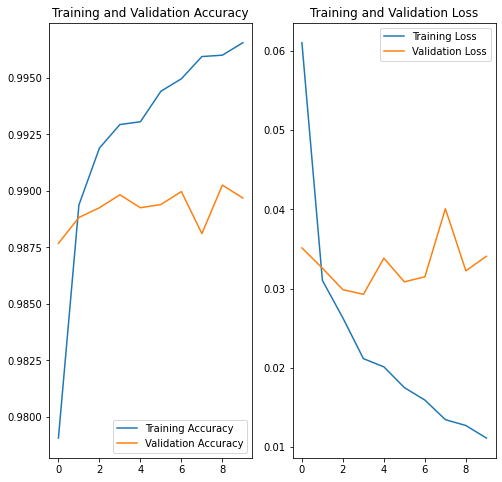

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Predictions**

In [13]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)



['cat' 'dog']
['dog' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat' 'cat' 'dog' 'dog' 'dog'
 'dog' 'cat' 'cat' 'cat' 'dog' 'cat' 'dog' 'cat']


In [14]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0]
Predicted labels:  [1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0]


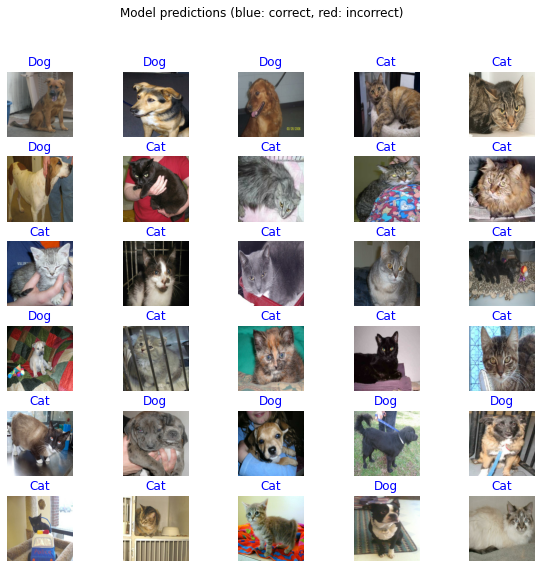

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

**Starting the process with Inception and loading it**

In [16]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


**Compiling again**

In [17]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 10

history_a = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
509/509 [==============================] - 214s 421ms/step - loss: 0.0460 - accuracy: 0.9859 - val_loss: 0.0184 - val_accuracy: 0.9947
Epoch 2/10
509/509 [==============================] - 210s 413ms/step - loss: 0.0202 - accuracy: 0.9932 - val_loss: 0.0169 - val_accuracy: 0.9946
Epoch 3/10
509/509 [==============================] - 211s 414ms/step - loss: 0.0165 - accuracy: 0.9942 - val_loss: 0.0178 - val_accuracy: 0.9950
Epoch 4/10
509/509 [==============================] - 209s 411ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.0164 - val_accuracy: 0.9947
Epoch 5/10
509/509 [==============================] - 208s 410ms/step - loss: 0.0117 - accuracy: 0.9960 - val_loss: 0.0205 - val_accuracy: 0.9940
Epoch 6/10
509/509 [==============================] - 208s 409ms/step - loss: 0.0104 - accuracy: 0.9963 - val_loss: 0.0170 - val_accuracy: 0.9941
Epoch 7/10
509/509 [==============================] - 208s 409ms/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.0177 -

**Visualizing the accuracies and losses with the help of Inception Model**

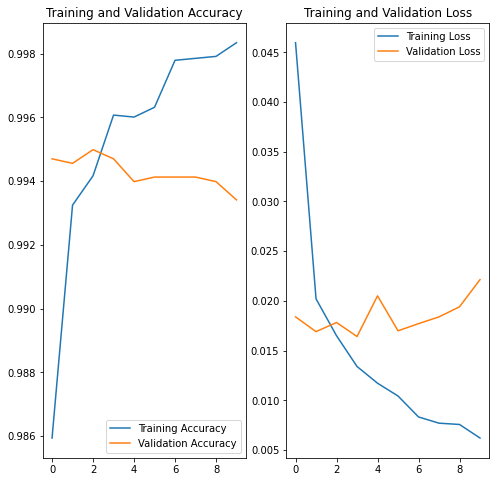

In [18]:
acc_a = history_a.history['accuracy']
val_acc_b = history_a.history['val_accuracy']

loss_p = history_a.history['loss']
val_loss_b = history_a.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_a, label='Training Accuracy')
plt.plot(epochs_range, val_acc_b, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_p, label='Training Loss')
plt.plot(epochs_range, val_loss_b, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**The Visualization Differences Between Mobile Net And Inception Models**

It presents some minor changes in both of these accuracies.

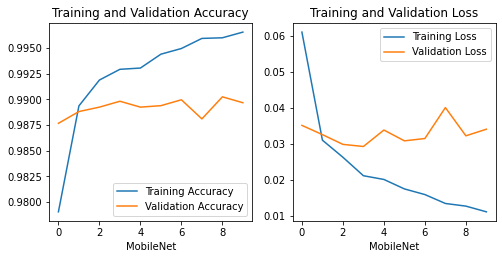

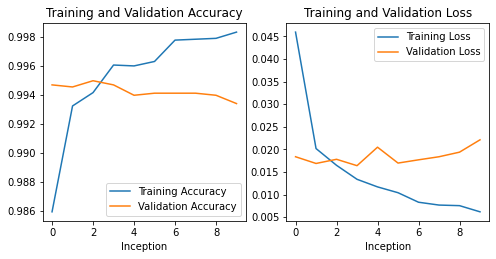

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('MobileNet')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('MobileNet')
plt.show()


acc_a = history_a.history['accuracy']
val_acc_b = history_a.history['val_accuracy']

loss_p = history_a.history['loss']
val_loss_b = history_a.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 3)
plt.plot(epochs_range, acc_a, label='Training Accuracy')
plt.plot(epochs_range, val_acc_b, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Inception')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, loss_p, label='Training Loss')
plt.plot(epochs_range, val_loss_b, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Inception')
plt.show()



In [20]:
print('The accuracy of MobileNet is', max(acc), '         ' ,'The accuracy of Inception model is', max(acc_a))
print('The validation accuracy of the model is', max(val_acc), '       ', 'The validation accuraxcy of the model is', max(val_acc_b))
print('The loss of MobileNet is', max(loss),'        ', 'The loss of Inception model is', max(loss_p))
print('The validation loss of the model is', max(val_loss), '  ', 'The validation loss of the model is', max(val_loss_b))


The accuracy of MobileNet is 0.99656081199646           The accuracy of Inception model is 0.9983418583869934
The validation accuracy of the model is 0.9902564883232117         The validation accuraxcy of the model is 0.9949849843978882
The loss of MobileNet is 0.061041686683893204          The loss of Inception model is 0.04596535116434097
The validation loss of the model is 0.04007996991276741    The validation loss of the model is 0.02213383838534355


Thanks!

Dheeraj Sharma